#Trabalho de DeepLearning.
O objetivo deste trabalho, é treinar uma rede neural que seja capaz de fazer reconhecimento facial. Com o modelo pronto, vamos colocá-lo em uma aplicação, para que essa rede neural tenha um uso prática, e possamos ver o funcionamento do modelo na prática.
Para realizar este trabalho, vamos utilizar as bibliotecas OpenCV2, Tensorflow,especialmente o módulo do Keras e Kyvi.
Este notebook irá treinar o modelo. Faremos a aplicação separadamente.

#Vamos começar importando as bibliotecas necesárias

In [109]:
#instaling the dependencies
%pip install tensorflow==2.13.0 opencv-python matplotlib
#!pip install numpy --upgrade

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
#importing dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#importing tensorflow functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

c:\Users\Suporte\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#Tratando o uso da GPU

In [3]:
#Avoid Out Of Memory problems by controlling the GPU growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#Ajustando os diretórios e as rotas para os dados.
Separamos os dados em "positivos", "negativos" e âncoras. Fazemos essa separação como uma espécie de "validação" dos dados para o treino do modelo.

In [ ]:
#uncompress the Labelled faces in the wild dataset
!tar -xf lfw.tgz

#uncompress the data zip
!unzip data.zip

In [4]:
#Setting up the the PATH

POS_PATH = os.path.join('data', 'positivo')
NEG_PATH = os.path.join('data', 'negativo')
ANC_PATH = os.path.join('data', 'ancora')

In [114]:
#make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Não é possível criar um arquivo já existente: 'data\\positivo'

In [5]:
#moving the images to the data repositories
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

#Configurando o acesso a Webcam

In [6]:
#import library for unique images name
import uuid

In [8]:
# Established connection to the Webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()

    #cut down the frame to 250x250
    frame = frame[120:120+250, 200:200+250, :]

    #Collecting anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)


    #Collecting positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)


    #show image on the screen
    cv2.imshow('Image Collection', frame)

    #breaking
    if(cv2.waitKey(1) & 0XFF == ord('q')):
        break

#release webcam
cap.release()
#Close the image show frame
cv2.destroyAllWindows()

In [7]:
import os
import uuid

In [8]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [14]:
img_path = os.path.join(ANC_PATH, r'data\ancora\0023a35f-6f66-11ef-8afd-9303d5b78e15.jpg')
img = cv2.imread(img_path)

if img is not None:
    augmented_images = data_aug(img)
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())
else:
    print(f"Failed to read image from {img_path}")


Failed to read image from data\ancora\data\ancora\0023a35f-6f66-11ef-8afd-9303d5b78e15.jpg


In [15]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

KeyboardInterrupt: 

In [121]:
#getting the images path inside tensorflow
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [122]:
dir_test = anchor.as_numpy_iterator()

In [123]:
print(dir_test.next())

b'data\\ancora\\f13cbf50-6f65-11ef-9230-9303d5b78e15.jpg'


#Pré processamento das imagens

In [124]:
#pre processing images
def preprocess(file_path):
    #read image from file_path
    byte_img = tf.io.read_file(file_path)
    #load the image
    img = tf.io.decode_jpeg(byte_img)
    #pre processing steps - resizing the image to be 100x100
    img = tf.image.resize(img, (100,100))

    img = img / 255.0
    return img

In [125]:
img = preprocess(r'data\ancora\0023a35f-6f66-11ef-8afd-9303d5b78e15.jpg')

In [126]:
img.numpy().max()

1.0

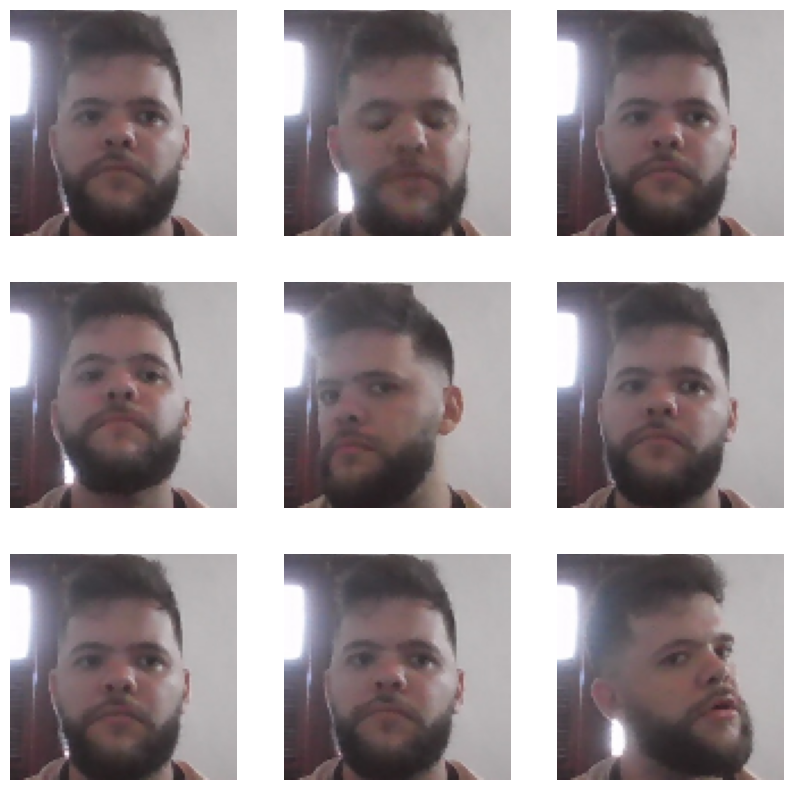

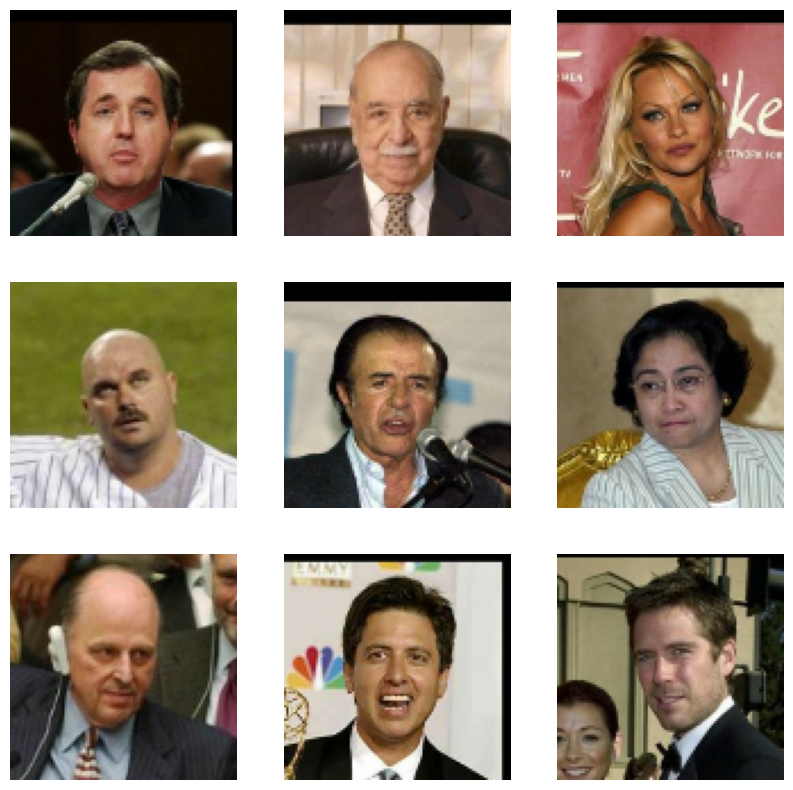

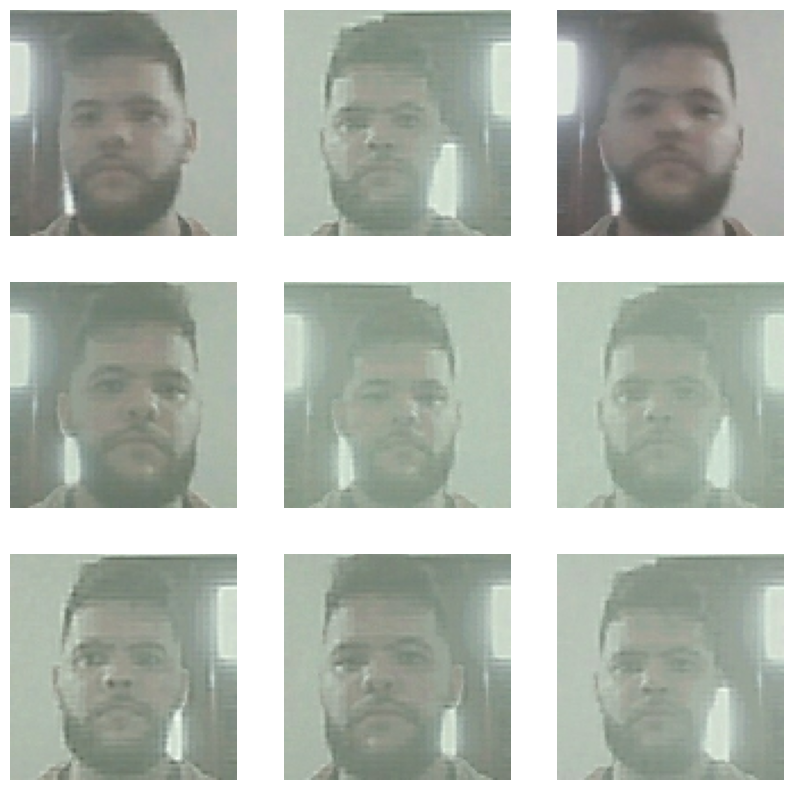

In [127]:
ancora = anchor.map(preprocess)
positivo = positive.map(preprocess)
negativo = negative.map(preprocess)

#showing the images
plt.figure(figsize=(10,10))
for i, img in enumerate(ancora.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

#showing the images negative
plt.figure(figsize=(10,10))
for i, img in enumerate(negativo.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

#showing the images positive
plt.figure(figsize=(10,10))
for i, img in enumerate(positivo.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [128]:
#labelled dataset
positivos = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negativos = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positivos.concatenate(negativos)


In [129]:
samples = data.as_numpy_iterator()

In [130]:
exampple = samples.next()

In [131]:
exampple

(b'data\\ancora\\ff280dd3-6f65-11ef-802a-9303d5b78e15.jpg',
 b'data\\positivo\\9dcbdc33-6f77-11ef-bfb1-9303d5b78e15.jpg',
 1.0)

In [132]:
#pre process the files (images) from our actual directory
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [133]:
res = preprocess_twin(*exampple)

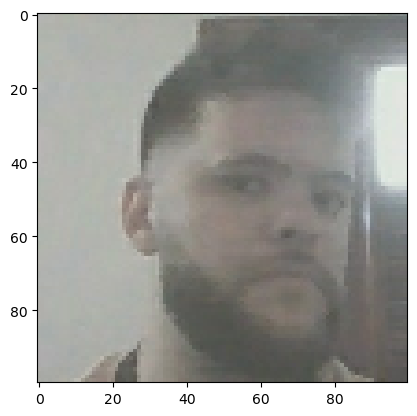

In [134]:
plt.imshow(res[1])

In [135]:
res[2]

1.0

#Preparando o treino

In [136]:
#Build the dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [137]:
#creating the training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [138]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [139]:
train_samples = train_data.as_numpy_iterator()

In [140]:
train_sample = train_samples.next()

In [141]:
len(train_sample[0])

16

In [142]:
inp = Input(shape = (100,100,3))

#Definindo as funções de ativação

In [143]:
c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)

In [144]:
c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

In [145]:
c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

In [146]:
c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation = 'sigmoid')(f1)

In [147]:
mod = Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [148]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

#Criando a nossa camada de Embedding

In [149]:
#making the embedding layer
def make_embedding():
    inp = Input(shape = (100,100,3))

    #first block
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)

    #second block
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

    #third block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

    #final embedding block
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)

    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [150]:
embedding = make_embedding()

In [151]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

#Criando a nossa camada "Siamese"

In [152]:
#Siamese L1 Distance class
class L1Dist(Layer):
    #init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [153]:
l1 = L1Dist()

In [154]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [155]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [156]:
siamese_layer = L1Dist()

In [157]:
distances = siamese_layer(inp_embedding, val_embedding)

In [158]:
classifier = Dense(1, activation='sigmoid')(distances)

In [159]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [160]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

#Definindo o modelo

In [161]:
def make_siamese_model():
    #Anchor image input
    input_image = Input(name = 'input_img', shape=(100,100,3))

    #Validation image on the network
    validation_image = Input(name = 'validation_img', shape=(100,100,3))

    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    #classification layer
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [162]:
siamese_model = make_siamese_model()

In [163]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

#Função de perda e otimização

In [164]:
#loss function
binary_cross_loss = tf.losses.BinaryCrossentropy() #there is a variation if the data are not normalized

In [165]:
#optimizer
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

#Configurando os checkpoints do treino e a função auxiliar de treino

In [202]:
#building the training checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [208]:
#train step function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:

        #get anchor and positive/negative images
        X = batch[:2]
        #get label
        y = batch[2]

        #forward pass
        yhat = siamese_model(X, training = True)
        #claculate loss
        loss = binary_cross_loss(y,yhat)

        #calculate gradients
        grad = tape.gradient(loss, siamese_model.trainable_variables)

        #claculate updated weights and apply to siamese model
        opt.apply_gradients(zip(grad,siamese_model.trainable_variables))

        return loss

In [203]:
test_batch = train_data.as_numpy_iterator()

In [204]:
batch_1 = test_batch.next()

In [205]:
X = batch_1[:2]

In [206]:
y = batch_1[2]

In [207]:
y

array([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

#Definindo a função de treino e as épocas

In [200]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [185]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [186]:
EPOCHS = 50

In [201]:
# Ensure the checkpoint directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
train(train_data, EPOCHS)



 Epoch 1/50
2/2 [==============================] - 8s 3s/step
0.00010793804 1.0 1.0

 Epoch 2/50
2/2 [==============================] - 7s 3s/step
0.00015058261 1.0 1.0

 Epoch 3/50
2/2 [==============================] - 9s 4s/step
0.00011076931 1.0 1.0

 Epoch 4/50
2/2 [==============================] - 9s 4s/step
3.552251e-05 1.0 1.0

 Epoch 5/50
2/2 [==============================] - 9s 4s/step
3.6261776e-05 1.0 1.0

 Epoch 6/50
2/2 [==============================] - 9s 4s/step
7.384549e-05 1.0 1.0

 Epoch 7/50
2/2 [==============================] - 9s 4s/step
0.00018953053 1.0 1.0

 Epoch 8/50
2/2 [==============================] - 8s 4s/step
0.00021074193 1.0 1.0

 Epoch 9/50
2/2 [==============================] - 9s 4s/step
0.00017788871 1.0 1.0

 Epoch 10/50
2/2 [==============================] - 10s 5s/step
9.438498e-05 1.0 1.0


FailedPreconditionError: C:\Users\Suporte\OneDrive\Área de Trabalho\Projeto_Machine_Learning\training_checkpoints is not a directory

#Testando o modelo

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
test_var = test_data.as_numpy_iterator().next()

In [ ]:
y_true

array([0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[9.9994528e-01],
       [3.4257256e-12],
       [1.7940533e-13],
       [9.9999326e-01],
       [1.0000000e+00],
       [2.1115368e-14],
       [5.7853502e-08],
       [1.0000000e+00],
       [7.9795011e-11],
       [9.9868864e-01],
       [1.9800711e-06],
       [6.6291287e-12],
       [9.9829930e-01],
       [9.9988270e-01],
       [4.6497254e-11],
       [2.4879489e-12]], dtype=float32)

In [ ]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]

In [ ]:
y_true

array([1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [ ]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

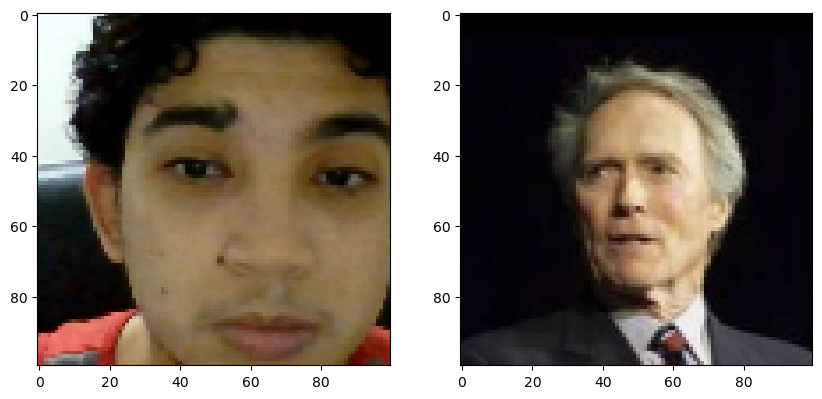

In [ ]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

#Salvando o modeloe fazendo o teste do modelo salvo

In [ ]:
# Save weights
siamese_model.save('siamesemodel.h5')

C:\Users\paugu\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
L1Dist

__main__.L1Dist

In [ ]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[1.7578505e-13],
       [6.3071141e-12],
       [9.6985912e-07],
       [1.9223067e-12],
       [9.9999988e-01],
       [1.0000000e+00],
       [2.2155980e-03],
       [9.9999994e-01],
       [9.2701065e-08],
       [1.0000000e+00],
       [9.9999994e-01],
       [1.0067001e-07],
       [4.8495491e-12],
       [4.0228829e-06],
       [1.2048662e-12],
       [2.0869670e-08]], dtype=float32)

In [ ]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [ ]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00aae39e-2586-11ee-86ee-0ccc47e025cf.jpg',
 '00aae39f-2586-11ee-8e75-0ccc47e025cf.jpg',
 '00ac17cb-2587-11ee-b756-0ccc47e025cf.jpg',
 '00ad45db-2586-11ee-b767-0ccc47e025cf.jpg',
 '00bd8750-2586-11ee-9160-0ccc47e025cf.jpg',
 '00bd8751-2586-11ee-a120-0ccc47e025cf.jpg',
 '00c7ea2d-2586-11ee-bfe5-0ccc47e025cf.jpg',
 '00c7ea2e-2586-11ee-865d-0ccc47e025cf.jpg',
 '0a040a32-1f58-11ee-b60e-0ccc47e025cf.jpg',
 '0a070d6e-2587-11ee-a6cd-0ccc47e025cf.jpg',
 '0a070d6f-2587-11ee-9fff-0ccc47e025cf.jpg',
 '0a16d139-2586-11ee-bdd2-0ccc47e025cf.jpg',
 '0a17f78f-2587-11ee-9d36-0ccc47e025cf.jpg',
 '0a17f790-2587-11ee-803f-0ccc47e025cf.jpg',
 '0a29fc5b-2586-11ee-9fc9-0ccc47e025cf.jpg',
 '0a34e727-2587-11ee-9633-0ccc47e025cf.jpg',
 '0a34e728-2587-11ee-8447-0ccc47e025cf.jpg',
 '0a34e729-2587-11ee-a595-0ccc47e025cf.jpg',
 '0a52cab1-2586-11ee-964d-0ccc47e025cf.jpg',
 '0a52cab2-2586-11ee-bd63-0ccc47e025cf.jpg',
 '0a52cab3-2586-11ee-8e15-0ccc47e025cf.jpg',
 '0a53c3b8-1f58-11ee-ab9c-0ccc47e025cf.jpg',
 '0a61e0f4

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\00aae39e-2586-11ee-86ee-0ccc47e025cf.jpg
application_data\verification_images\00aae39f-2586-11ee-8e75-0ccc47e025cf.jpg
application_data\verification_images\00ac17cb-2587-11ee-b756-0ccc47e025cf.jpg
application_data\verification_images\00ad45db-2586-11ee-b767-0ccc47e025cf.jpg
application_data\verification_images\00bd8750-2586-11ee-9160-0ccc47e025cf.jpg
application_data\verification_images\00bd8751-2586-11ee-a120-0ccc47e025cf.jpg
application_data\verification_images\00c7ea2d-2586-11ee-bfe5-0ccc47e025cf.jpg
application_data\verification_images\00c7ea2e-2586-11ee-865d-0ccc47e025cf.jpg
application_data\verification_images\0a040a32-1f58-11ee-b60e-0ccc47e025cf.jpg
application_data\verification_images\0a070d6e-2587-11ee-a6cd-0ccc47e025cf.jpg
application_data\verification_images\0a070d6f-2587-11ee-9fff-0ccc47e025cf.jpg
application_data\verification_images\0a16d139-2586-11ee-bdd2-0ccc47e025cf.jpg
application_data\verification_images\0a17f78f-2587-11ee-9d36-0cc

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [ ]:
results